In [9]:
import torch
SEED = 123
torch.manual_seed(SEED) 

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torchsummary import summary
from torchinfo import summary
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import warnings
from tqdm import tqdm
from datetime import datetime
from torch.autograd import Variable
warnings.filterwarnings('ignore')

from PIL import Image
import os
import glob

# check OS is Window or Mac
import platform
device = torch.device("cpu")

if platform.system() == 'Windows':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif platform.system() == 'Darwin':
    try:
        device = torch.device("mps")
    except:
        device = torch.device("cpu")

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})

print(device)

cpu


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

cnn_model = load_model("./models/" + f'adversarial_LeNet5.pth')
fcn_model = load_model("./models/" + f'adversarial_FCN.pth')


OSError: Unable to synchronously open file (file signature not found)

In [43]:

# Cargar modelos
fcn_model = load_model("./models/" + f'adversarial_FCN.pth', CustomFCNetwork())
cnn_model = load_model("./models/" + f'adversarial_LeNet5.pth', LeNet5V1())

# Listas para almacenar las imágenes y etiquetas originales
original_images = []
original_labels = []

path = 'data_split/test/'

# Iterar sobre las clases y obtener una imagen por clase
for clse in range(1, 11):
    ruta = os.path.join(path, str(clse))
    archivo = os.listdir(ruta)[100]
    
    if archivo.endswith(".png"):
        ruta_img = os.path.join(ruta, archivo)

        # Cargar y preprocesar la imagen original
        original_img = Image.open(ruta_img).convert("RGB")
        original_img = transform(original_img)
        original_images.append(original_img)
        original_labels.append(clse)


In [54]:

# Iterar sobre las clases y obtener una imagen por clase
for clse in range(1, 11):
    ruta = os.path.join(path, str(clse))
    archivo = os.listdir(ruta)[100]
    
    if archivo.endswith(".png"):
        ruta_img = os.path.join(ruta, archivo)

        # Cargar y preprocesar la imagen original
        original_img = Image.open(ruta_img).convert("RGB")
        original_img = transform(original_img)
        original_images.append(original_img)
        original_labels.append(clse)



In [55]:
# Crear un DataLoader para las imágenes originales
original_dataset = list(zip(original_images, original_labels))
original_dataloader = DataLoader(original_dataset, batch_size=1, shuffle=False)


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

def get_penultimate_activation(model, img_tensor):
    # Obtener la activación de la capa penúltima
    with torch.no_grad():
        x = model.feature(img_tensor)
        x = model.classifier[:-1](torch.flatten(x, 1))  # Aplanar el tensor antes de pasar por la capa classifier
    return x

# Función para sintetizar estímulos coincidentes
def synthesize_stimulus(original_img_tensor, target_activation, model, num_iterations=1000, lr=0.1):
    # Crear un tensor inicial para la imagen sintetizada (se puede inicializar de manera aleatoria)
    synthesized_img_tensor = torch.rand_like(original_img_tensor, requires_grad=True)

    # Función de pérdida para igualar las activaciones
    criterion = nn.MSELoss()

    # Optimizador para actualizar la imagen sintetizada
    optimizer = optim.SGD([synthesized_img_tensor], lr=lr)

    # Iterar para optimizar la imagen sintetizada
    for _ in range(num_iterations):
        # Obtener la activación de la capa penúltima para la imagen sintetizada
        synthesized_activation = get_penultimate_activation(model, synthesized_img_tensor)

        # Calcular la pérdida entre la activación de la imagen sintetizada y la activación objetivo
        loss = criterion(synthesized_activation, target_activation.detach())

        # Retropropagar y actualizar la imagen sintetizada
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return synthesized_img_tensor.detach()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

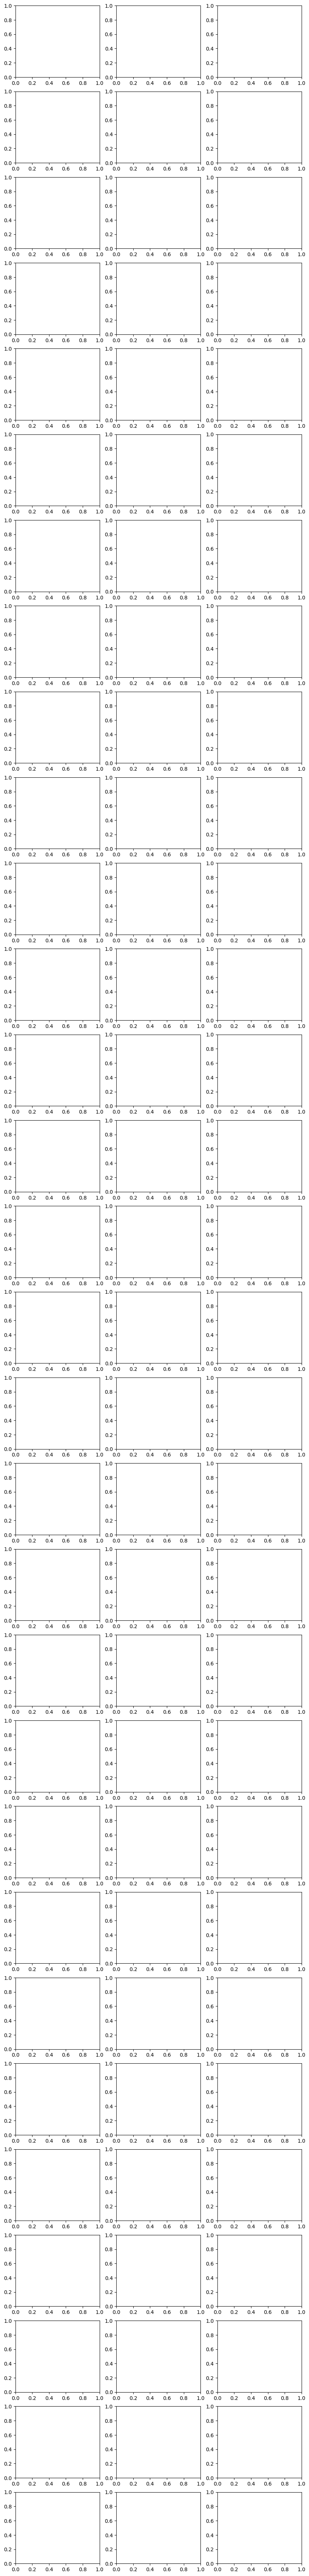

In [57]:

# Crear la figura
fig, axes = plt.subplots(len(original_labels), 3, figsize=(10, 3 * len(original_labels)))

# Iterar sobre las imágenes originales y mostrar las imágenes originales y sintetizadas
for i, (original_img, original_label) in enumerate(original_dataloader):
    # Obtener la activación de la capa penúltima para la CNN
    cnn_activation = get_penultimate_activation(cnn_model, original_img)

    # Sintetizar estímulo coincidente para la CNN
    synthesized_cnn_img = synthesize_stimulus(original_img, cnn_activation, cnn_model)

    # Obtener la activación de la capa penúltima para la FCN
    fcn_activation = get_penultimate_activation(fcn_model, original_img)

    # Sintetizar estímulo coincidente para la FCN
    synthesized_fcn_img = synthesize_stimulus(original_img, fcn_activation, fcn_model)

    # Columna 1: Original
    axes[i, 0].imshow(original_img.squeeze().permute(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Class {original_label.item()}\nOriginal")

    # Columna 2: Synthesized CNN
    axes[i, 1].imshow(synthesized_cnn_img.squeeze().permute(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Synthesized CNN\nClass {original_label.item()}")

    # Columna 3: Synthesized FCN
    axes[i, 2].imshow(synthesized_fcn_img.squeeze().permute(1, 2, 0))
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f"Synthesized FCN\nClass {original_label.item()}")

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()